# Basic Protein-Ligand Affinity Models
#Tutorial: Use machine learning to model protein-ligand affinity.

Written by Evan Feinberg and Bharath Ramsundar

Copyright 2016, Stanford University

This DeepChem tutorial demonstrates how to use mach.ine learning for modeling protein-ligand binding affinity

Overview:

In this tutorial, you will trace an arc from loading a raw dataset to fitting a cutting edge ML technique for predicting binding affinities. This will be accomplished by writing simple commands to access the deepchem Python API, encompassing the following broad steps:

1. Loading a chemical dataset, consisting of a series of protein-ligand complexes.
2. Featurizing each protein-ligand complexes with various featurization schemes. 
3. Fitting a series of models with these featurized protein-ligand complexes.
4. Visualizing the results.

First, let's point to a "dataset" file. This can come in the format of a CSV file or Pandas DataFrame. Regardless
of file format, it must be columnar data, where each row is a molecular system, and each column represents
a different piece of information about that system. For instance, in this example, every row reflects a 
protein-ligand complex, and the following columns are present: a unique complex identifier; the SMILES string
of the ligand; the binding affinity (Ki) of the ligand to the protein in the complex; a Python `list` of all lines
in a PDB file for the protein alone; and a Python `list` of all lines in a ligand file for the ligand alone.

This should become clearer with the example. (Make sure to set `DISPLAY = True`)


In [1]:
# set DISPLAY = True when running tutorial
DISPLAY = False
# set PARALLELIZE to true if you want to use ipyparallel
PARALLELIZE = False
import warnings
warnings.filterwarnings('ignore')

In [2]:
import deepchem as dc
from deepchem.utils import download_url

import os

download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/pdbbind_core_df.csv.gz")
data_dir = os.path.join(dc.utils.get_data_dir())
dataset_file= os.path.join(dc.utils.get_data_dir(), "pdbbind_core_df.csv.gz")
raw_dataset = dc.utils.save.load_from_disk(dataset_file)

Let's see what `dataset` looks like:

In [3]:
print("Type of dataset is: %s" % str(type(raw_dataset)))
print(raw_dataset[:5])
print("Shape of dataset is: %s" % str(raw_dataset.shape))

Type of dataset is: <class 'pandas.core.frame.DataFrame'>
  pdb_id                                             smiles  \
0   2d3u        CC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   
1   3cyx  CC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1CCCCC...   
2   3uo4        OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1   
3   1p1q                         CC1ONC(O)C1CC([NH3+])C(O)O   
4   3ag9  NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC[NH2...   

                                          complex_id  \
0    2d3uCC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   
1  3cyxCC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1C...   
2    3uo4OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1   
3                     1p1qCC1ONC(O)C1CC([NH3+])C(O)O   
4  3ag9NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC...   

                                         protein_pdb  \
0  ['HEADER    2D3U PROTEIN\n', 'COMPND    2D3U P...   
1  ['HEADER    3CYX PROTEIN\n', 'COMPND    3CYX P...   
2  ['HEADER    3UO4 PROTEIN\n', 'COMPND    3UO4 P...   
3 

One of the missions of ```deepchem``` is to form a synapse between the chemical and the algorithmic worlds: to be able to leverage the powerful and diverse array of tools available in Python to analyze molecules. This ethos applies to visual as much as quantitative examination:

In [4]:
import nglview
import tempfile
import os
import mdtraj as md
import numpy as np
import deepchem.utils.visualization
#from deepchem.utils.visualization import combine_mdtraj, visualize_complex, convert_lines_to_mdtraj

def combine_mdtraj(protein, ligand):
  chain = protein.topology.add_chain()
  residue = protein.topology.add_residue("LIG", chain, resSeq=1)
  for atom in ligand.topology.atoms:
      protein.topology.add_atom(atom.name, atom.element, residue)
  protein.xyz = np.hstack([protein.xyz, ligand.xyz])
  protein.topology.create_standard_bonds()
  return protein

def visualize_complex(complex_mdtraj):
  ligand_atoms = [a.index for a in complex_mdtraj.topology.atoms if "LIG" in str(a.residue)]
  binding_pocket_atoms = md.compute_neighbors(complex_mdtraj, 0.5, ligand_atoms)[0]
  binding_pocket_residues = list(set([complex_mdtraj.topology.atom(a).residue.resSeq for a in binding_pocket_atoms]))
  binding_pocket_residues = [str(r) for r in binding_pocket_residues]
  binding_pocket_residues = " or ".join(binding_pocket_residues)

  traj = nglview.MDTrajTrajectory( complex_mdtraj ) # load file from RCSB PDB
  ngltraj = nglview.NGLWidget( traj )
  ngltraj.representations = [
  { "type": "cartoon", "params": {
  "sele": "protein", "color": "residueindex"
  } },
  { "type": "licorice", "params": {
  "sele": "(not hydrogen) and (%s)" %  binding_pocket_residues
  } },
  { "type": "ball+stick", "params": {
  "sele": "LIG"
  } }
  ]
  return ngltraj

def visualize_ligand(ligand_mdtraj):
  traj = nglview.MDTrajTrajectory( ligand_mdtraj ) # load file from RCSB PDB
  ngltraj = nglview.NGLWidget( traj )
  ngltraj.representations = [
    { "type": "ball+stick", "params": {"sele": "all" } } ]
  return ngltraj

def convert_lines_to_mdtraj(molecule_lines):
  molecule_lines = molecule_lines.strip('[').strip(']').replace("'","").replace("\\n", "").split(", ")
  tempdir = tempfile.mkdtemp()
  molecule_file = os.path.join(tempdir, "molecule.pdb")
  with open(molecule_file, "w") as f:
    for line in molecule_lines:
        f.write("%s\n" % line)
  molecule_mdtraj = md.load(molecule_file)
  return molecule_mdtraj

first_protein, first_ligand = raw_dataset.iloc[0]["protein_pdb"], raw_dataset.iloc[0]["ligand_pdb"]
protein_mdtraj = convert_lines_to_mdtraj(first_protein)
ligand_mdtraj = convert_lines_to_mdtraj(first_ligand)
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)

In [5]:
ngltraj = visualize_complex(complex_mdtraj)
ngltraj

NGLWidget()

Now that we're oriented, let's use ML to do some chemistry. 

So, step (2) will entail featurizing the dataset.

The available featurizations that come standard with deepchem are ECFP4 fingerprints, RDKit descriptors, NNScore-style bdescriptors, and hybrid binding pocket descriptors. Details can be found on ```deepchem.io```.

In [6]:
grid_featurizer = dc.feat.RdkitGridFeaturizer(
    voxel_width=16.0, feature_types="voxel_combined", 
    voxel_feature_types=["ecfp", "splif", "hbond", "pi_stack", "cation_pi", "salt_bridge"], 
    ecfp_power=5, splif_power=5, parallel=True, flatten=True)
compound_featurizer = dc.feat.CircularFingerprint(size=128)

Note how we separate our featurizers into those that featurize individual chemical compounds, compound_featurizers, and those that featurize molecular complexes, complex_featurizers.

Now, let's perform the actual featurization. Calling ```loader.featurize()``` will return an instance of class ```Dataset```. Internally, ```loader.featurize()``` (a) computes the specified features on the data, (b) transforms the inputs into ```X``` and ```y``` NumPy arrays suitable for ML algorithms, and (c) constructs a ```Dataset()``` instance that has useful methods, such as an iterator, over the featurized data. This is a little complicated, so we will use MoleculeNet to featurize the PDBBind core set for us.

In [7]:
PDBBIND_tasks, (train_dataset, valid_dataset, test_dataset), transformers = dc.molnet.load_pdbbind_grid(split='random')
#print(dc.molnet.load_pdbbind_grid(split='random', reload=False))

Loading dataset from disk.
TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.


Now, we conduct a train-test split. If you'd like, you can choose `splittype="scaffold"` instead to perform a train-test split based on Bemis-Murcko scaffolds.

We generate separate instances of the Dataset() object to hermetically seal the train dataset from the test dataset. This style lends itself easily to validation-set type hyperparameter searches, which we will illustate in a separate section of this tutorial. 

The performance of many ML algorithms hinges greatly on careful data preprocessing. Deepchem comes standard with a few options for such preprocessing.

Now, we're ready to do some learning! 

To fit a deepchem model, first we instantiate one of the provided (or user-written) model classes. In this case, we have a created a convenience class to wrap around any ML model available in Sci-Kit Learn that can in turn be used to interoperate with deepchem. To instantiate an ```SklearnModel```, you will need (a) task_types, (b) model_params, another ```dict``` as illustrated below, and (c) a ```model_instance``` defining the type of model you would like to fit, in this case a ```RandomForestRegressor```.

In [8]:
from sklearn.ensemble import RandomForestRegressor

sklearn_model = RandomForestRegressor(n_estimators=100)
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

In [9]:
from deepchem.utils.evaluate import Evaluator
import pandas as pd

metric = dc.metrics.Metric(dc.metrics.r2_score)

evaluator = Evaluator(model, train_dataset, transformers)
train_r2score = evaluator.compute_model_performance([metric])
print("RF Train set R^2 %f" % (train_r2score["r2_score"]))

evaluator = Evaluator(model, valid_dataset, transformers)
valid_r2score = evaluator.compute_model_performance([metric])
print("RF Valid set R^2 %f" % (valid_r2score["r2_score"]))

computed_metrics: [0.8853709076989028]
RF Train set R^2 0.885371
computed_metrics: [0.24299559830714745]
RF Valid set R^2 0.242996


In this simple example, in few yet intuitive lines of code, we traced the machine learning arc from featurizing a raw dataset to fitting and evaluating a model. 

Here, we featurized only the ligand. The signal we observed in R^2 reflects the ability of circular fingerprints and random forests to learn general features that make ligands "drug-like."

In [10]:
predictions = model.predict(test_dataset)
print(predictions)

[5.4144 5.6237 5.4758 6.7253 7.2027 5.3732 6.9986 7.1167 6.0284 6.1725
 6.6449 6.7692 7.4198 6.325  6.8163 6.005  6.4791 6.851  6.8021 6.8329]


In [11]:
# TODO(rbharath): This cell visualizes the ligand with highest predicted activity. Commenting it out for now. Fix this later
#from deepchem.utils.visualization import visualize_ligand

#top_ligand = predictions.iloc[0]['ids']
#ligand1 = convert_lines_to_mdtraj(dataset.loc[dataset['complex_id']==top_ligand]['ligand_pdb'].values[0])
#if DISPLAY:
#    ngltraj = visualize_ligand(ligand1)
#    ngltraj

In [12]:
# TODO(rbharath): This cell visualizes the ligand with lowest predicted activity. Commenting it out for now. Fix this later
#worst_ligand = predictions.iloc[predictions.shape[0]-2]['ids']
#ligand1 = convert_lines_to_mdtraj(dataset.loc[dataset['complex_id']==worst_ligand]['ligand_pdb'].values[0])
#if DISPLAY:
#    ngltraj = visualize_ligand(ligand1)
#    ngltraj

# The protein-ligand complex view.

The preceding simple example, in few yet intuitive lines of code, traces the machine learning arc from featurizing a raw dataset to fitting and evaluating a model. 

In this next section, we illustrate ```deepchem```'s modularity, and thereby the ease with which one can explore different featurization schemes, different models, and combinations thereof, to achieve the best performance on a given dataset. We will demonstrate this by examining protein-ligand interactions. 

In the previous section, we featurized only the ligand. The signal we observed in R^2 reflects the ability of grid fingerprints and random forests to learn general features that make ligands "drug-like." In this section, we demonstrate how to use hyperparameter searching to find a higher scoring ligands.

In [13]:
def rf_model_builder(model_params, model_dir):
  sklearn_model = RandomForestRegressor(**model_params)
  return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "n_estimators": [10, 50, 100],
    "max_features": ["auto", "sqrt", "log2", None],
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/12
hyperparameters: {'n_estimators': 10, 'max_features': 'auto'}
computed_metrics: [0.09939209697523932]
Model 1/12, Metric r2_score, Validation set 0: 0.099392
	best_validation_score so far: 0.099392
Fitting model 2/12
hyperparameters: {'n_estimators': 10, 'max_features': 'sqrt'}
computed_metrics: [-0.0695298978560297]
Model 2/12, Metric r2_score, Validation set 1: -0.069530
	best_validation_score so far: 0.099392
Fitting model 3/12
hyperparameters: {'n_estimators': 10, 'max_features': 'log2'}
computed_metrics: [-0.13807775139920508]
Model 3/12, Metric r2_score, Validation set 2: -0.138078
	best_validation_score so far: 0.099392
Fitting model 4/12
hyperparameters: {'n_estimators': 10, 'max_features': None}
computed_metrics: [0.032727077194550924]
Model 4/12, Metric r2_score, Validation set 3: 0.032727
	best_validation_score so far: 0.099392
Fitting model 5/12
hyperparameters: {'n_estimators': 50, 'max_features': 'auto'}
computed_metrics: [0.169640982514488]
Model 5/12,

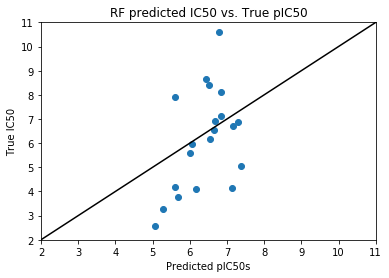

In [14]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

rf_predicted_test = best_rf.predict(test_dataset)
rf_true_test = test_dataset.y
plt.scatter(rf_predicted_test, rf_true_test)
plt.xlabel('Predicted pIC50s')
plt.ylabel('True IC50')
plt.title(r'RF predicted IC50 vs. True pIC50')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()